The purpose of this notebook is to visualize the simulated catheter's forward kinematics as it moves through the trajectory recorded in history.p

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import mpld3
# mpld3.enable_notebook()

sns.set_style("dark")
sns.set_context("talk")

In [3]:
with open( "history_square.p", "rb" ) as input_file:
            history = pickle.load(input_file)

In [4]:
# Some arrays change size (x_desired, x_current), which make the asarray(list()) method ineffective
def RepackageArray(array, max_width, zero = 0):
    new_array = np.zeros((array.size, max_width))
    for i, row in enumerate(array):
        for j, num in enumerate(row):
            new_array[i, j] = num
    return new_array - new_array[zero,:]

In [5]:
time, x_current, x_full, x_desired, q, q_desired, J, W, amps, amps_smooth = history[0,:,:]
# For some reason this gives you 1D arrays of arrays that won't let you index through them. Below allows that.
time_array = np.asarray(list(time))
start = 500
end   = round(history.shape[-1] - 0.35*history.shape[-1])
x_current = RepackageArray(x_current, 5, start)
x_full = np.asarray(list(x_full))
x_desired = RepackageArray(x_desired, 5, start)
q = np.asarray(list(q))
q_desired = np.asarray(list(q_desired))
# print(J.shape)
# J = np.asarray(list(J))
# W = np.asarray(list(W))
# amps = np.asarray(list(amps))
# amps_smooth = np.asarray(list(amps_smooth))

x, y, z, a, e = [x_full[start:,0] - x_full[start,0],
                 x_full[start:,1] - x_full[start,1], 
                 x_full[start:,2] - x_full[start,2],
                 x_full[start:,3] - x_full[start,3],
                 x_full[start:,4] - x_full[start,4]]





In [6]:
from matplotlib import animation

from tempfile import NamedTemporaryFile

from IPython.display import HTML
import io
import base64

mywriter = animation.FFMpegWriter(fps = 20)


In [7]:
import sys
sys.path.append("../")
import ModelInterface
robot = ModelInterface.catheter()


In [8]:
print(q.shape)

(5794, 10)


In [9]:
import time

tend = 579
body = robot.GetPointsAlongBody(q[tend,:] - q[0,:])
# plt.plot(body[:,0], body[:,2], '.')
print(q[tend,:] - q[0,:])
print(x[tend])
print(x_full[tend,:] - x_full[start,:])
print(body[:,:3])

[-0.00492571 -0.00738856 -0.00985141 -0.01723997 -0.00738856 -0.00738856
 -0.00492571 -0.01970283  0.          0.        ]
0.0
[ 0.          0.          0.          0.02197266  0.        ]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.05412395e-04   8.10824790e-04   4.44444432e+00]
 [  1.62164951e-03   3.24329902e-03   8.88888790e+00]
 [  3.64871115e-03   7.29742230e-03   1.33333300e+01]
 [  6.48659697e-03   1.29731939e-02   1.77777699e+01]
 [  1.01353065e-02   2.02706130e-02   2.22222068e+01]
 [  1.45948391e-02   2.91896783e-02   2.66666400e+01]
 [  1.98651941e-02   3.97303882e-02   3.11110688e+01]
 [  2.59463706e-02   5.18927412e-02   3.55554924e+01]
 [  3.28383676e-02   6.56767351e-02   3.99999101e+01]]


In [10]:
# plt.plot(q[:100,:])
# print(q[0,:])

In [11]:
def getModelPrediction(q_offset, q_scale):
    q_model = (q[502:]-q_offset).dot(q_scale)
#     print(q_model[5])
    body = np.asarray([robot.GetPointsAlongBody(qi, num = 10, with_sheath = True) for qi in q_model])
#     print(body[5])
    return body

In [12]:
q_offset = np.copy(q[1,:])
q_offset[-2] += 30 #anticipating flip with q[-1]
scalar = 0.1
q_scale  = np.eye(10) * 0.15
q_scale[8,8] = 0
q_scale[9,9] = 0
q_scale[8,9] = -1.6
body = getModelPrediction(q_offset, q_scale)

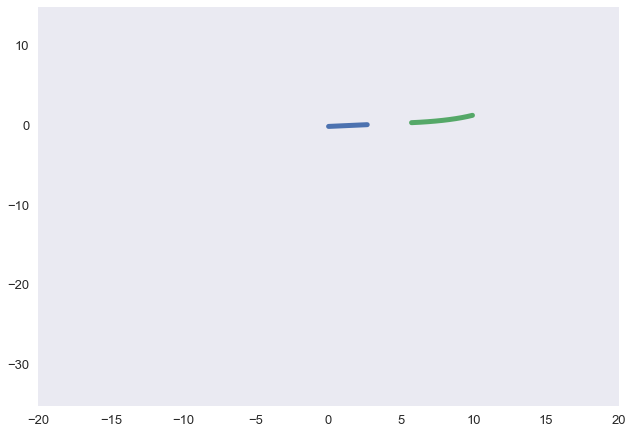

In [19]:
# based on http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 115), ylim=(-35, 15))
ax = plt.axes(xlim=(-20, 20), ylim=(-35, 15))


sheath, = ax.plot([], [], lw=5)
leader, = ax.plot([], [], lw=5)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
frame_number = 200
start_offset = 1000
data_length  = len(time_array) - start_offset
resolution   = int(np.floor(data_length / frame_number)) - 5 #for some reason need fudge factor

def nextframe(i):
    i = i*resolution + start_offset
    num_points = 10
    sheath.set_data(body[i, :num_points,2], -body[i, :num_points,1])
    leader.set_data(body[i, num_points:,2], -body[i, num_points:,1])
    line.set_data(y[i], -z[i])
#     print(y[i],-z[i])
    return sheath, leader, line

# call the animator.  blit=True means only re-draw the parts that have changed.
save_time = time.perf_counter()
anim = animation.FuncAnimation(fig, nextframe, init_func=init,
                               frames=frame_number, interval=20, blit=True)

anim.save('robot_motion.mp4', writer = animation.FFMpegWriter(fps = 20))

video = io.open('robot_motion.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
# print(time.perf_counter() - save_time)

In [14]:
plt.plot(J[:,:,4])

IndexError: too many indices for array

In [ ]:
J[0,:,:]

In [ ]:
from matplotlib import animation, pyplot as plt
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls autoplay>
 <source src="data:{0}
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.m4v') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim.to_html5_video()
    # prevent figure displayed as a PNG below the animation
    plt.close()
    
    return VIDEO_TAG.format(anim.to_html5_video())

animation.Animation._repr_html_ = anim_to_html

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 45), ylim=(-15, 15))
sheath, = ax.plot([], [], lw=2)
leader, = ax.plot([], [], lw=2)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.

animation.FuncAnimation(fig, nextframe, init_func=init,
                               frames=300, interval=20, blit=True)

In [ ]:
xd = np.zeros(1000)
for i in range(1000):
    body = robot.GetPointsAlongBody(q[i], num = 2, with_sheath = True)
    xd[i] = z[i] - body[-1, 2]
plt.plot(xd)

In [ ]:
plt.plot(q[:,-2])

In [16]:
video = io.open('robot_motion.mp4', 'r+b').read()
encoded = base64.b64encode(video)
# print(encoded)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))